<a href="https://colab.research.google.com/github/marta-brasola/FinancialMarketAnalytics/blob/prova/financial_09_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [151]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [152]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

In [153]:
def get_log_returns(data):
  """
  obiettivo è calcolare i returns delle stocks
  """
  prices = data['PX_LAST'].reset_index()
  prices = prices.rename_axis(None, axis=1)
  prices = prices.replace(0, np.NAN)
  prices = prices.fillna(np.nan)
  prices = prices.set_index('Date')
  returns = np.log(prices/prices.shift(1))
  returns = returns.iloc[1::]
  return returns

def calculate_quantile_returns(data_frame, column_name, returns_df, num_quantiles=5):
    """
    Calculate quantile returns based on the specified column in the DataFrame.
    """

    quantile_ranks = pd.DataFrame(index=data_frame.index, columns=data_frame.columns.levels[1])
    ind_rank = data_frame[column_name]
    ind_rank = ind_rank.replace(0, np.nan)

    for date in ind_rank.index:
        row_values = ind_rank.loc[date]
        # come mai c'è questa condizione del count?
        if row_values.count() > 1:
          ranks = pd.Series(row_values).rank(method='max')
          quintiles = pd.qcut(ranks, q=num_quantiles, labels=False)
          quantile_ranks.loc[date] = quintiles

    quantile_dfs = {}
    portfolio_returns = pd.DataFrame()

    for quantile in range(num_quantiles):
        filtered_df = returns_df[quantile_ranks == quantile]
        filtered_df_shifted = filtered_df
        quantile_dfs[quantile] = filtered_df_shifted
        portfolio_returns[quantile] = quantile_dfs[quantile].mean(axis=1).dropna()

    return quantile_dfs, portfolio_returns

# DA CONTROLLARE PRIMA DI CONSEGNARE PER DECIDERE SE TGLIERLI
# TUTTA LA PARTE DEI RITORNI CUMULATIVI

def calculate_cumulative_return(portfolio_returns):
    """
    Calculate the cumulative return of a portfolio.
    """
    return (1 + portfolio_returns).prod() - 1


def calculate_annualized_return(cumulative_return,portfolio_returns, num_periods=12):
    """
    Calculate the annualized return of a portfolio.
    """
    return (1 + cumulative_return) ** (num_periods / len(portfolio_returns)) - 1


def calculate_annual_volatility(portfolio_returns, num_periods=12):
    """
    Calculate the annualized volatility of a portfolio.
    """
    return portfolio_returns.std() * math.sqrt(num_periods)


def calculate_risk_adjusted_return(annualized_return, annual_volatility):
    """
    Calculate the risk-adjusted return (Sharpe ratio) of a portfolio.
    """
    return annualized_return / annual_volatility


def calculate_IR(portfolio_returns, benchmark_returns):
    """
    Calculate the Information Ratio.
    """

    active_return = portfolio_returns-benchmark_returns
    tracking_error = np.std(portfolio_returns-benchmark_returns)


    return active_return.mean() / tracking_error

In [154]:
df = pd.read_csv('/content/drive/MyDrive/financial/data/Euro_preprocessed.csv', header=[0,1], index_col=[0])

In [155]:
df = df.replace(0, np.nan)
df.head()

indicators 10_YEAR_MOVING_AVERAGE_PE                                     \
tickers                       02P GR 1BM GR 1PL GR 1VS GR 2HR GR 3W9 GR   
Date                                                                      
2003-01-31                       NaN    NaN    NaN    NaN    NaN    NaN   
2003-02-28                       NaN    NaN    NaN    NaN    NaN    NaN   
2003-03-31                       NaN    NaN    NaN    NaN    NaN    NaN   
2003-04-30                       NaN    NaN    NaN    NaN    NaN    NaN   
2003-05-30                       NaN    NaN    NaN    NaN    NaN    NaN   

indicators                               ... WACC_COST_EQUITY                  \
tickers    5AB GR 9AR GR A3TV SM AAD GR  ...           YRM IM YTY1V FH ZAR GR   
Date                                     ...                                    
2003-01-31    NaN    NaN     NaN    NaN  ...          10.8039   6.3797    NaN   
2003-02-28    NaN    NaN     NaN    NaN  ...          10.8039   6.3797    NaN   
2003-03-31    NaN    NaN     NaN    NaN  ...          10.8039   6.2664    NaN   
2003-04-30    NaN    NaN     NaN    NaN  ...          10.8039   6.2664    NaN   
2003-05-30    NaN    NaN     NaN    NaN  ...          10.8039   6.2664    NaN   

indicators                                                              
tickers       ZC FP   ZEL SM ZIGGO NA ZIL2 GR   ZO1 GR  ZOT SM   ZV IM  
Date                                                                    
2003-01-31   9.3182  12.5229      NaN     NaN  11.1423  6.8462  8.7721  
2003-02-28  11.7907  12.5229      NaN     NaN  11.1423  6.8462  8.7721  
2003-03-31  11.7907  11.3917      NaN  7.9502  11.1423  6.8462  8.7721  
2003-04-30  11.7907  11.3917      NaN  7.9502  11.1423  6.8462  8.7721  
2003-05-30  11.7907  11.3917      NaN  7.9502  11.1423  6.1677  8.7721  

[5 rows x 31920 columns]

## Checking null values

In [156]:
tot_values = 111*797
null_ind = df.isnull().groupby(level=0, axis=1).sum().sum(axis=0).reset_index()
null_ind.columns = ['indicators', 'null_values']
null_ind['perc_null_values'] = (null_ind['null_values'] / tot_values) * 100
null_ind.sort_values(by='perc_null_values', ascending=False)
ind_drop = list(null_ind[null_ind['perc_null_values']>50]['indicators'])
ind_drop

['10_YEAR_MOVING_AVERAGE_PE',
 'BEST_EPS',
 'EQY_DPS_NET_5YR_GROWTH',
 'T12M_DIL_EPS_CONT_OPS',
 'T12M_DIL_PE_CONT_OPS',
 'T12M_DVD_PAYOUT_RATIO']

In [157]:
df.drop(columns=ind_drop, inplace=True)
prova = len(df.columns.get_level_values(0).unique())
print(f"number of indicators remaining: {prova}")

number of indicators remaining: 34


In [158]:
null = {}
for ind in indicators:
  null[ind] = data_stack.reset_index().groupby('Date')[ind].apply(lambda x: x.isnull().sum())

null = pd.DataFrame.from_dict(null)
null = round(null / 797, 2) * 100

In [173]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

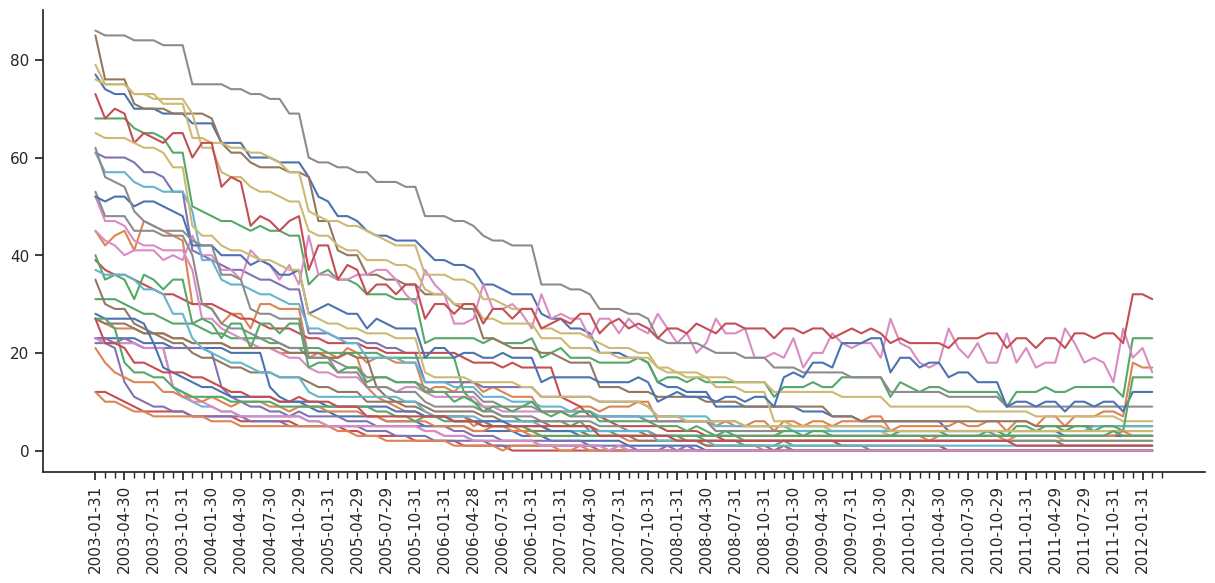

In [174]:
labels = df.index[::3]

plt.figure(figsize=(15,6))
plt.plot(null)
plt.xticks(rotation=90, ha='center', labels=labels, ticks=range(0, len(df.index), 3))
plt.xticks(rotation=45, ha='right', labels=['']*len(df.index), ticks=range(len(df.index)), minor=True)

plt.show()

## Univariate Strategy

In [160]:
returns = get_log_returns(df)

In [161]:
print(returns.shape)
returns.head()

(110, 798)


,02P GR,1BM GR,1PL GR,1VS GR,2HR GR,3W9 GR,5AB GR,9AR GR,A3TV SM,AAD GR,...,YRM IM,YTY1V FH,ZAR GR,ZC FP,ZEL SM,ZIGGO NA,ZIL2 GR,ZO1 GR,ZOT SM,ZV IM
Date,,,,,,,,,,,,,,,,,,,,,
2003-02-28,0.287682,-0.541159,NaN,0.154601,0.010380,0.045549,NaN,0.368801,0.221576,-0.200671,...,NaN,-0.023670,-0.040274,-0.108803,0.025081,NaN,-0.024713,NaN,-0.014286,NaN
2003-03-31,0.000000,-0.018727,NaN,0.232112,-0.034946,-0.115929,NaN,0.003222,-0.003714,-0.122796,...,NaN,-0.128106,0.125969,-0.113053,0.078275,NaN,0.028018,NaN,0.011922,NaN
2003-04-30,0.000000,0.000000,NaN,-0.074877,0.026262,-0.012579,-0.086221,0.114510,0.125197,0.077333,...,NaN,0.085286,-0.085695,0.263255,0.135976,NaN,0.292823,-0.065182,0.007880,NaN
2003-05-30,0.040822,0.000000,NaN,0.074877,0.006760,-0.024561,-0.388015,0.055791,-0.099765,-0.047628,...,NaN,0.033193,0.132873,-0.035233,0.101784,NaN,0.074108,-0.097732,0.092805,NaN
2003-06-30,-0.024293,0.119252,NaN,-0.077962,0.067901,-0.084557,-0.176351,0.052842,0.045276,0.275412,...,NaN,0.027432,0.009174,0.084447,-0.276132,NaN,0.305382,-0.004179,0.029580,NaN


In [162]:
indicators = df.columns.get_level_values(0).unique()

In [163]:
benchmark_returns = returns.mean(axis=1)

In [164]:
indicator_IR = pd.DataFrame(index=indicators, columns=['IR_top_quantile', 'IR_bottom_quantile', 'tracking_top_quantile',
                                                       'tracking_error_bottom_quantile', 'returns_top_quantile', 'returns_bottom_quantile'])

for indicator in indicators:
    result_dfs, portfolio_returns = calculate_quantile_returns(df, indicator, returns)
    indicator_IR.at[indicator, 'IR_top_quantile'] = calculate_IR(portfolio_returns[4], benchmark_returns)
    indicator_IR.at[indicator, 'IR_bottom_quantile'] = calculate_IR(portfolio_returns[0], benchmark_returns)
    indicator_IR.at[indicator, 'tracking_top_quantile'] = np.std(portfolio_returns[4]-benchmark_returns)
    indicator_IR.at[indicator, 'tracking_error_bottom_quantile'] = np.std(portfolio_returns[0]-benchmark_returns)
    indicator_IR.at[indicator, 'returns_top_quantile'] = np.mean(portfolio_returns[4]) * 100
    indicator_IR.at[indicator, 'returns_bottom_quantile'] = np.mean(portfolio_returns[0]) * 100


indicator_IR.sort_values('IR_top_quantile', ascending = False)

,IR_top_quantile,IR_bottom_quantile,tracking_top_quantile,tracking_error_bottom_quantile,returns_top_quantile,returns_bottom_quantile
indicators,,,,,,
RSI_9D,2.141123,-2.717937,0.022825,0.01865,5.42634,-4.529742
RSI_14D,1.753973,-1.756464,0.022738,0.022511,4.527477,-3.414823
RSI_30D,1.201953,-0.750993,0.022131,0.026025,3.199239,-1.415219
EQY_REC_CONS,0.953733,-0.838324,0.01255,0.016221,1.736173,-0.820675
PX_TO_TANG_BV_PER_SH,0.740319,-0.713526,0.010313,0.018436,1.302666,-0.776268
PX_TO_BOOK_RATIO,0.722828,-0.762302,0.015423,0.023078,1.654054,-1.220022
PE_RATIO,0.643904,-0.627384,0.014012,0.018692,1.441417,-0.633525
CURRENT_EV_TO_T12M_EBITDA,0.582441,-0.485095,0.015215,0.018816,1.42539,-0.373539
CURRENT_EV_TO_12M_SALES,0.37707,-0.470959,0.015111,0.015268,1.108995,-0.179847


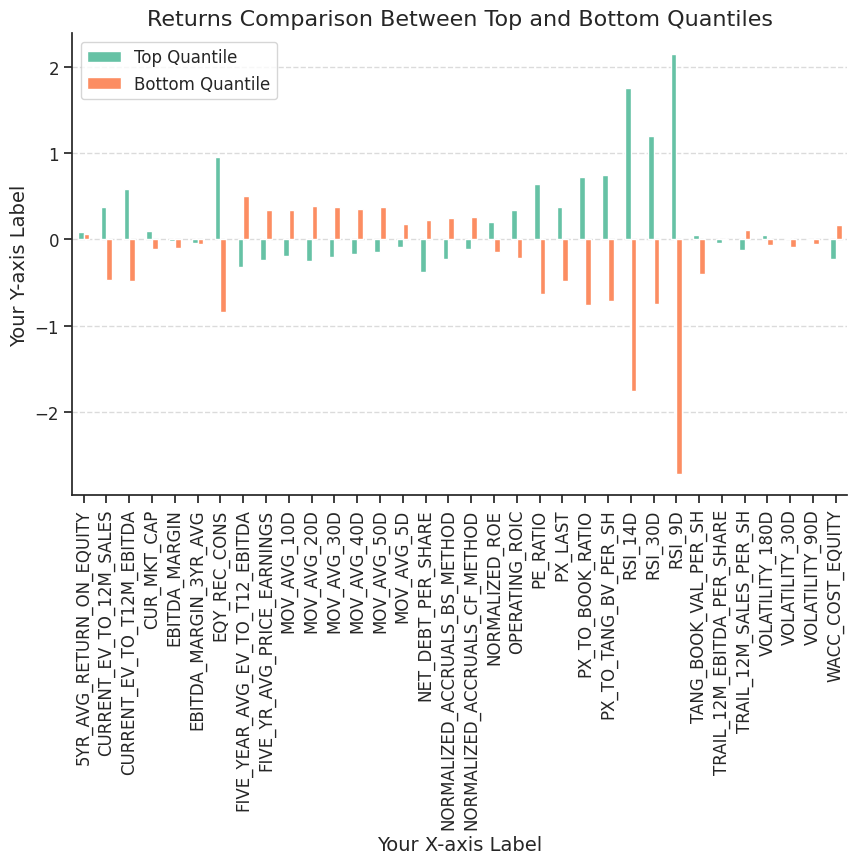

In [175]:
sns.set_palette('Set2')
# Assuming 'indicator_IR' is your DataFrame
ax = indicator_IR[['IR_top_quantile','IR_bottom_quantile']].plot(kind='bar', figsize=(10, 6))

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Returns Comparison Between Top and Bottom Quantiles', fontsize=16)
plt.xlabel('Your X-axis Label', fontsize=14)
plt.ylabel('Your Y-axis Label', fontsize=14)
plt.legend(['Top Quantile', 'Bottom Quantile'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90, ha='center', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
sns.set_palette('Set2')
# Assuming 'indicator_IR' is your DataFrame
ax = indicator_IR[['returns_top_quantile', 'returns_bottom_quantile']].plot(kind='bar', figsize=(14, 8))

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Returns Comparison Between Top and Bottom Quantiles', fontsize=16)
plt.xlabel('Your X-axis Label', fontsize=14)
plt.ylabel('Your Y-axis Label', fontsize=14)
plt.legend(['Top Quantile', 'Bottom Quantile'], fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90, ha='center', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Turnover

- turnover assoluto
- turnover relativo rispetto alle azioni in portafolio
- quanto permane un'azione in portafoglio?

In [191]:
first_quantile_stocks = pd.DataFrame(index=df.index, columns=indicators)
last_quantile_stocks = pd.DataFrame(index=df.index, columns=indicators)


# Loop through each indicator
for ind in indicators:
    result_dfs, portfolio_returns = calculate_quantile_returns(df, ind, returns)

    # For each date, store the list of best stocks in the corresponding column
    for index, row in result_dfs[4].iterrows():
        first_quantile_stocks.loc[index, ind] = list(row.dropna().index)

    for index, row in result_dfs[0].iterrows():
        last_quantile_stocks.loc[index, ind] = list(row.dropna().index)


first_quantile_date = first_quantile_stocks.reset_index()
last_quantile_date = last_quantile_stocks.reset_index()


turnover_first_quantile = pd.DataFrame(index = df.index)
turnover_last_quantile = pd.DataFrame(index = df.index)

In [198]:
def turnover_select(indicator, stocks, stocks_date):

    expanded_df2 = stocks[indicator].explode()
    merged_df = pd.merge(stocks_date[[indicator, 'Date']],
                         expanded_df2, how='right',
                         left_on='Date', right_on='Date')

    changed_stocks = (
        merged_df.groupby('Date')[indicator + '_y']
        .apply(set)
        .diff()
        .apply(lambda x: list(x) if isinstance(x, set) else [])
    )

    if stocks.equals(first_quantile_stocks) and stocks_date.equals(first_quantile_date):
      turnover_first_quantile[indicator] = changed_stocks.apply(lambda x: len(x))

    elif stocks.equals(last_quantile_stocks) and stocks_date.equals(last_quantile_date):
      turnover_last_quantile[indicator] = changed_stocks.apply(lambda x: len(x))

In [199]:
for ind in indicators:

    turnover_select(indicator=ind,
                    stocks=first_quantile_stocks,
                    stocks_date=first_quantile_date)

    turnover_select(indicator=ind,
                    stocks=last_quantile_stocks,
                    stocks_date= last_quantile_date)

In [188]:
'''list1 = [item for sublist in first_quantile_stocks['PX_TO_BOOK_RATIO'][2:3].values for item in sublist]
list2 = [item for sublist in first_quantile_stocks['PX_TO_BOOK_RATIO'][3:4].values for item in sublist]

differences = set(list2) - set(list1)

# Print the count of different elements
print(f"Number of different elements: {len(differences)}")'''

Number of different elements: 13


In [217]:
stats = round(turnover_first_quantile.mean(),2).T.reset_index()
stats.columns = ['indicators', 'average_first_quantile']
stats2 = round(turnover_last_quantile.mean(),2).reset_index()
stats2.columns = ['indicators', 'average_last_quantile']
stats = stats.merge(stats2, how='inner', on='indicators')

In [219]:
stats.sort_values(by='average_first_quantile', ascending=False)

,indicators,average_first_quantile,average_last_quantile
31,VOLATILITY_30D,51.50,59.41
26,RSI_9D,34.04,31.70
6,EQY_REC_CONS,33.87,28.87
24,RSI_14D,27.28,23.44
32,VOLATILITY_90D,21.62,26.04
25,RSI_30D,17.88,12.76
16,NORMALIZED_ACCRUALS_BS_METHOD,16.67,19.84
20,PE_RATIO,16.01,15.64
2,CURRENT_EV_TO_T12M_EBITDA,13.07,13.84
30,VOLATILITY_180D,12.37,14.98


## Multivariate strategy  

In [166]:
def calculate_quantile_returns_zscore(data_frame, column_name, returns_df, num_quantiles=5):
    """
    Calculate quantile returns based on the specified column in the DataFrame.
    """

    quantile_ranks = pd.DataFrame(index=data_frame.index, columns=data_frame.columns)
    ind_rank = data_frame[column_name]
    ind_rank = ind_rank.replace(0, np.nan)

    for date in ind_rank.index:
        row_values = ind_rank.loc[date]
        if row_values.count() > 1:
          ranks = pd.Series(row_values).rank(method='max')
          quintiles = pd.qcut(ranks, q=num_quantiles, labels=False)
          quantile_ranks.loc[date] = quintiles

    quantile_dfs = {}
    portfolio_returns = pd.DataFrame()

    for quantile in range(num_quantiles):
        filtered_df = returns_df[quantile_ranks == quantile]
        filtered_df_shifted = filtered_df
        quantile_dfs[quantile] = filtered_df_shifted
        portfolio_returns[quantile] = quantile_dfs[quantile].mean(axis=1).dropna()

    return quantile_dfs, portfolio_returns

In [167]:
z_score = (df-df.T.groupby(level=0).mean().T)/df.T.groupby(level=0).std().T

levels = [0.1, 0.25, 0.5, 1, 1.5, 2]
indicator_IR_z = pd.DataFrame(index=levels, columns=['IR_max_quant', 'tracking_error_max', 'returns_max'])

for selection_level in levels:
    sel_z_score = z_score[indicator_IR[(indicator_IR['IR_top_quantile']>selection_level)].index].merge(-z_score[indicator_IR[(indicator_IR['IR_bottom_quantile']>selection_level)].index], on='Date')
    final = sel_z_score.T.groupby(level=1).sum().T

    result_dfs_2, portfolio_returns_2 = calculate_quantile_returns_zscore(final, final.columns, returns)

    indicator_IR_z.at[selection_level, 'IR_max_quant'] = calculate_IR(portfolio_returns_2[4], benchmark_returns)
    indicator_IR_z.at[selection_level, 'tracking_error_max'] = np.std(portfolio_returns_2[4]-benchmark_returns)
    indicator_IR_z.at[selection_level, 'returns_max'] = np.mean(portfolio_returns_2[4]) * 100

indicator_IR_z

,IR_max_quant,tracking_error_max,returns_max
0.10,1.577063,0.02072,3.806905
0.25,1.744382,0.019971,4.022865
0.50,1.742151,0.020798,4.162527
1.00,1.705975,0.022515,4.380173
1.50,1.964897,0.0226,4.97978
2.00,2.141123,0.022825,5.42634


In [168]:
indicator_IR_z_2 = pd.DataFrame(columns=['IR_max_quant', 'tracking_error_max', 'returns_max'])

pos_factors = [
    "PE_RATIO",
    "CURRENT_EV_TO_T12M_EBITDA",
    "TANG_BOOK_VAL_PER_SH",
    "EBITDA_MARGIN",
    "RSI_9D",
    "5YR_AVG_RETURN_ON_EQUITY",
    "PX_TO_BOOK_RATIO",
    "VOLATILITY_180D"
]

neg_factors = [
    "NET_DEBT_PER_SHARE"
]

sel_z_score = z_score[pos_factors].merge(-z_score[neg_factors], on='Date')
final = sel_z_score.T.groupby(level=1).sum().T

result_dfs_3, portfolio_returns_3 = calculate_quantile_returns_zscore(final, final.columns, returns)

indicator_IR_z_2.at[0, 'IR_max_quant'] = calculate_IR(portfolio_returns_3[4], benchmark_returns)
indicator_IR_z_2.at[0, 'tracking_error_max'] = np.std(portfolio_returns_3[4]-benchmark_returns)
indicator_IR_z_2.at[0, 'returns_max'] = np.mean(portfolio_returns_3[4]) * 100

indicator_IR_z_2

,IR_max_quant,tracking_error_max,returns_max
0,2.214473,0.015053,3.872585


## Machine Learning

In [ ]:
df2 = df.copy(deep=True)
df2.drop(df2.head(1).index, inplace=True)
r = pd.DataFrame(returns.values, index=returns.index,  columns=pd.MultiIndex.from_product([['RETURNS'], returns.columns]))
df2 = pd.concat([df2, r], axis=1)
data_stack = df2.stack()
data_stack

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

def xs_forest(df, n_estimators=4):
    '''Build a cross-sectional forest model and
    output the pipeline at each timestamp'''
    # sklearn does not have an imputing method unless specified
    df = df[df['RETURNS'].notna()]
    # do not leave out test sample in our training pipeline
    X_train, y_train = df.drop(columns='RETURNS').values, df['RETURNS'].values

    model = make_pipeline(SimpleImputer(missing_values=np.nan, strategy='mean'),
                          RandomForestRegressor(n_estimators=n_estimators,
                                                random_state=42))
    model.fit(X_train, y_train)
    # we return the model instead of slope estimations
    # such that we can transform the next-period data later
    return model

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
subset = data_stack.loc['2003-03-31':'2004-02-27']

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = KNNImputer(n_neighbors=2)

subset_mean = imp_mean.fit_transform(subset)
subset_knn = imputer.fit_transform(subset)

In [ ]:
subset = subset.values

In [ ]:
type(subset_knn)

In [ ]:
subset_no_null.shape

In [ ]:
num_columns = subset.shape[1]
fig, axs = plt.subplots(num_columns, figsize=(10, 4*num_columns))

# Plot the distribution of each array in each subplot
for i in range(num_columns):
    axs[i].hist(subset[:, i], alpha=0.5, label='Subset', bins=20)
    axs[i].hist(subset_mean[:, i], alpha=0.5, label='Subset Mean', bins=20)
    axs[i].hist(subset_knn[:, i], alpha=0.5, label='Subset KNN', bins=20)
    axs[i].set_title(f'Column {i+1}')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
df_no_null = pd.DataFrame(data=subset_no_null, index=subset.index, columns=subset.columns)

In [ ]:
subset['5YR_AVG_RETURN_ON_EQUITY'].plot(kind='hist')

In [ ]:
df_no_null['5YR_AVG_RETURN_ON_EQUITY'].plot(kind='hist')

In [ ]:
ls_forest = {}
ts = df.index.to_list()
dt = 12                                # 1-year rolling window
for i in range(len(ts)-dt+1):
    df3 = data_stack.loc[ts[i]:ts[i+dt-1]]
    ls_forest[ts[i+dt-1]] = xs_forest(df3)    # add the model corresponding to i+dt-1, last period of rolling window
df_forest = pd.Series(ls_forest)

In [ ]:
res = {}

for t in df_forest.shift(1).index.to_list():
    df4 = data_stack.loc[t]
    df4 = df4[df4['RETURNS'].notna()]
    X_test, y_test = df4.drop(columns='RETURNS').values, df4['RETURNS'].values
    try:
        forest = df_forest.shift(1).loc[t]
        y_pred = forest.predict(X_test).reshape(-1)  # prediction array reshaped to 1d
    except:
        y_pred = np.nan
    res[t] = pd.DataFrame({'RETURNS': y_test, 'PREDICTIONS': y_pred}, index=df4.index)

res = pd.concat(res)
res.index.names = ['Date', 'ticker']

In [ ]:
df_ret = res.drop('2003-12-31', level=0, axis=0)['RETURNS']
df_pred = res.drop('2003-12-31', level=0, axis=0)['PREDICTIONS']
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(df_ret, df_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(df_ret, df_pred))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(df_ret, df_pred, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(df_ret, df_pred))
print('R^2:', metrics.r2_score(df_ret, df_pred))